In [22]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import *
import cv2 as cv

In [23]:
Image_SIZE = (64,64)
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
BATCH_SIZE  = 64
ALPHA = 0.001

EPOCHS = 100 # number of epochs
TEST_SIZE = 0.2
# TRAIN_SIZE=int(18*BATCH_SIZE)


WEIGHT_DECAY = 0.001
PATENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE = 5
MIN_LR = 1e-6

class_labels = {0:	'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

(train_images, train_labels), (test_images, test_labels)  = tf.keras.datasets.cifar10.load_data()
train_images.shape,train_labels.shape,test_images.shape,test_labels.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

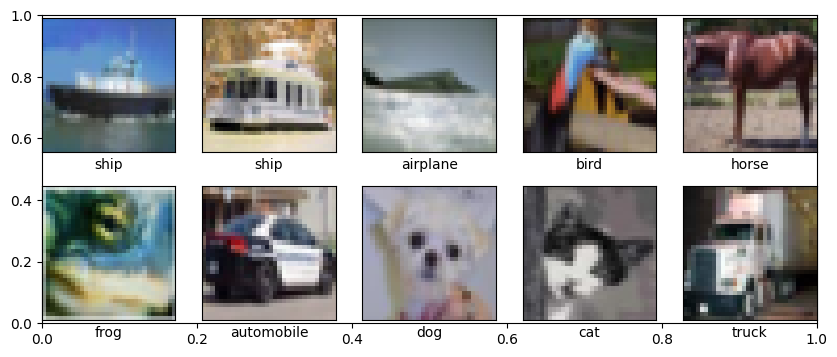

In [24]:
def fn_plot_images(data,labels):
    n_images = 10
    plt.subplots(figsize=(10,4))
    for i in range(n_images):
        plt.subplot(2,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        rand= np.random.randint(0,len(data))
        image = data[rand]
        cv.resize(image,(64,64),interpolation=cv.INTER_CUBIC)
        plt.imshow(image)
        # plt.xlabel(labels[rand][0])
        plt.xlabel(class_labels[labels[rand][0]])

fn_plot_images(train_images,train_labels)


In [25]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images,train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images,test_labels))

train_ds = train_ds.shuffle(buffer_size = train_images.shape[0]).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(buffer_size = test_images.shape[0]).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [26]:
for data ,labels in train_ds:
    print(data.shape,labels)

(64, 32, 32, 3) tf.Tensor(
[[7]
 [8]
 [0]
 [1]
 [0]
 [8]
 [6]
 [5]
 [6]
 [5]
 [7]
 [2]
 [2]
 [3]
 [6]
 [0]
 [2]
 [6]
 [5]
 [7]
 [3]
 [3]
 [1]
 [9]
 [7]
 [2]
 [8]
 [3]
 [8]
 [7]
 [9]
 [7]
 [4]
 [1]
 [2]
 [2]
 [7]
 [0]
 [2]
 [4]
 [7]
 [9]
 [1]
 [5]
 [4]
 [8]
 [4]
 [6]
 [6]
 [2]
 [5]
 [0]
 [7]
 [1]
 [4]
 [4]
 [0]
 [2]
 [9]
 [1]
 [8]
 [4]
 [1]
 [1]], shape=(64, 1), dtype=uint8)
(64, 32, 32, 3) tf.Tensor(
[[8]
 [0]
 [8]
 [0]
 [4]
 [5]
 [7]
 [3]
 [5]
 [0]
 [3]
 [5]
 [6]
 [3]
 [6]
 [9]
 [3]
 [4]
 [8]
 [9]
 [5]
 [6]
 [7]
 [4]
 [7]
 [0]
 [4]
 [4]
 [2]
 [7]
 [0]
 [8]
 [4]
 [2]
 [9]
 [2]
 [7]
 [3]
 [6]
 [5]
 [5]
 [9]
 [6]
 [2]
 [2]
 [6]
 [1]
 [8]
 [7]
 [8]
 [3]
 [4]
 [0]
 [1]
 [9]
 [0]
 [8]
 [6]
 [3]
 [0]
 [6]
 [2]
 [3]
 [4]], shape=(64, 1), dtype=uint8)
(64, 32, 32, 3) tf.Tensor(
[[1]
 [3]
 [4]
 [5]
 [6]
 [5]
 [6]
 [1]
 [6]
 [6]
 [9]
 [5]
 [3]
 [3]
 [4]
 [2]
 [9]
 [3]
 [1]
 [7]
 [1]
 [4]
 [4]
 [1]
 [4]
 [2]
 [5]
 [0]
 [0]
 [6]
 [0]
 [8]
 [9]
 [5]
 [6]
 [8]
 [5]
 [0]
 [0]
 [8]
 [9]
 [4]
 [0]
 [0]

In [ ]:
def build_model(input_shape,num_classes):
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape=input_shape))
    model.add(tf.keras.layers.Rescaling(1.0/255))

    #Set1
    model.add(tf.keras.layers.Conv2D(32,(3,3),padding='same',activation='relu'))  #(64*64*32)
    model.add(tf.keras.layers.MaxPool2D()) #(32,32,32)

    #Set2
    model.add(tf.keras.layers.Conv2D(64,(3,3),padding='valid',activation='relu'))  #(30*30*64)
    model.add(tf.keras.layers.MaxPool2D()) #(15,15,64)

    #Set3
    model.add(tf.keras.layers.Conv2D(128,(3,3),padding='valid',activation='relu'))  #(13*13*128)
    model.add(tf.keras.layers.MaxPool2D()) #(6,6,128)

    #Set4
    model.add(tf.keras.layers.Conv2D(128,(3,3),padding='valid',activation='relu')) #(4,4,128)
    model.add(tf.keras.layers.MaxPool2D()) #(2,2,128)


    model.add(tf.keras.layers.Flatten())

    ## Head
    model.add(tf.keras.layers.Dense(256,activation='relu'))
    model.add(tf.keras.layers.Dense(128,activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes))

    optimize = tf.keras.optimizers.Adam(learning_rate=ALPHA)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(optimizer=optimize,loss=loss_fn,metrics=['accuracy'])

    return model

In [28]:
len(class_labels)

10

In [29]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

In [30]:
input_shape=[IMAGE_WIDTH,IMAGE_HEIGHT,3]
model = build_model(input_shape,len(class_labels))

In [31]:
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=MIN_LR,
)

es_callback = tf.keras.callbacks.EarlyStopping(

    monitor="val_loss",
    min_delta=0,
    patience=PATENCE,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)


EPOCHS = 100 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
# TRAIN_SIZE=int(18*BATCH_SIZE)


WEIGHT_DECAY = 0.001
PATENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE = 5
MIN_LR = 1e-6

In [32]:
history = model.fit(train_ds,validation_data=test_ds,epochs=20,callbacks=[lr_callback,es_callback])

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.4203 - loss: 1.5922 - val_accuracy: 0.5429 - val_loss: 1.2937 - learning_rate: 0.0010
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.5773 - loss: 1.2008 - val_accuracy: 0.6224 - val_loss: 1.0912 - learning_rate: 0.0010
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.6388 - loss: 1.0341 - val_accuracy: 0.6509 - val_loss: 1.0009 - learning_rate: 0.0010
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.6780 - loss: 0.9271 - val_accuracy: 0.6645 - val_loss: 0.9665 - learning_rate: 0.0010
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7053 - loss: 0.8463 - val_accuracy: 0.6800 - val_loss: 0.9233 - learning_rate: 0.0010
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7277 - loss: 0.7812 - val_accuracy: 0.6797 - val_loss: 0.9249 - learning_rate: 0.0010
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7471 - l

In [40]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

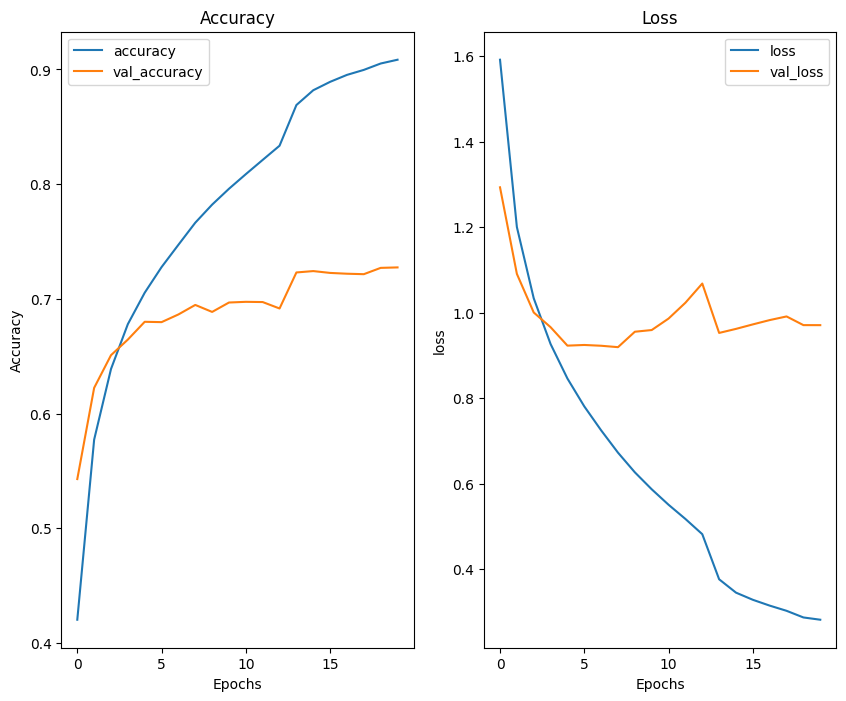

In [33]:
def plot_graph(history):
    keys = list(history.history.keys())
    fig,ax = plt.subplots(1,2,figsize=(10,8))

    ax[0].plot(history.epoch,history.history[keys[0]],label = keys[0])
    ax[0].plot(history.epoch,history.history[keys[2]],label = keys[2])
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.epoch,history.history[keys[1]],label = keys[1])
    ax[1].plot(history.epoch,history.history[keys[3]],label = keys[3])
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

plot_graph(history)

## With  Regularizations dropout

In [37]:
import tensorflow as tf

ALPHA = 0.001

def build_model(input_shape, num_classes):
    """
    Builds a Sequential CNN model with L2 Regularization and Dropout.
    
    Args:
        input_shape (tuple): Shape of the input images (e.g., (64, 64, 3)).
        num_classes (int): Number of output classes for classification.
        
    Returns:
        tf.keras.Model: The compiled Keras model.
    """
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape=input_shape))
    model.add(tf.keras.layers.Resizing(64, 64, interpolation="bilinear"))
    model.add(tf.keras.layers.Rescaling(1.0/255))

    # Set1 (64x64x3 )

    model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(l2=1e-2))) #(64*64*32)
    model.add(tf.keras.layers.MaxPool2D()) #(32*32*32)
    model.add(tf.keras.layers.Dropout(0.3))

    # Set2 (32x32x32)
    model.add(tf.keras.layers.Conv2D(64, (3,3), padding='valid', activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(l2=1e-2))) #(30*30*64)
    model.add(tf.keras.layers.MaxPool2D()) #(15*15*64)
    model.add(tf.keras.layers.Dropout(0.3))

    # Set3 (15x15x64)
    model.add(tf.keras.layers.Conv2D(128, (3,3), padding='valid', activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(l2=1e-2))) #(13*13*128)
    model.add(tf.keras.layers.MaxPool2D()) #(6,6,128)
    model.add(tf.keras.layers.Dropout(0.5))

    # # Set4 (6x6x128 -> 2x2x64)
    model.add(tf.keras.layers.Conv2D(64,(2,2),padding='valid',activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=1e-4))) #(4*4*64)
    # Output size calculation: 2 - 2 + 1 = 1x1 feature map.
    model.add(tf.keras.layers.MaxPool2D()) #(2*2*64)


    model.add(tf.keras.layers.Flatten())

    ## Head (Dense Layers)
    model.add(tf.keras.layers.Dense(256,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    

    model.add(tf.keras.layers.Dense(num_classes))

    # Compile the model
    optimize = tf.keras.optimizers.Adam(learning_rate=ALPHA)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(optimizer=optimize, loss=loss_fn, metrics=['accuracy'])

    return model


In [38]:
input_shape=[IMAGE_WIDTH,IMAGE_HEIGHT,3]
model = build_model(input_shape,len(class_labels))

In [39]:
history = model.fit(train_ds,validation_data=test_ds,epochs=20,callbacks=[lr_callback,es_callback])

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 87ms/step - accuracy: 0.2706 - loss: 2.0449 - val_accuracy: 0.3551 - val_loss: 1.8170 - learning_rate: 0.0010
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 68s 87ms/step - accuracy: 0.3736 - loss: 1.7673 - val_accuracy: 0.4063 - val_loss: 1.6972 - learning_rate: 0.0010
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 68s 87ms/step - accuracy: 0.4087 - loss: 1.6816 - val_accuracy: 0.4269 - val_loss: 1.6728 - learning_rate: 0.0010
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 68s 86ms/step - accuracy: 0.4313 - loss: 1.6303 - val_accuracy: 0.4532 - val_loss: 1.5953 - learning_rate: 0.0010
Epoch 5/20
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4370 - loss: 1.6087
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
782/782 ━━━━━━━━━━━━━━━━━━━━ 68s 86ms/step - accuracy: 0.4421 - loss: 1.5997 - val_accuracy: 0.4737 - val_loss: 1.5444 - learning_rate: 0.0010
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 67s 86ms/step - accuracy: 0.4729 - lo

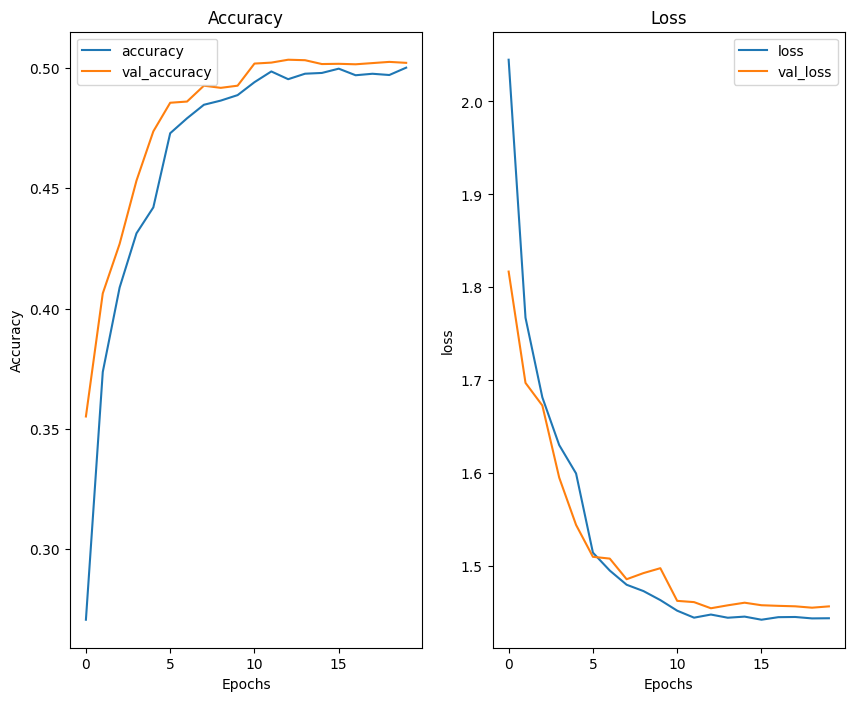

In [40]:
def plot_graph(history):
    keys = list(history.history.keys())
    fig,ax = plt.subplots(1,2,figsize=(10,8))

    ax[0].plot(history.epoch,history.history[keys[0]],label = keys[0])
    ax[0].plot(history.epoch,history.history[keys[2]],label = keys[2])
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.epoch,history.history[keys[1]],label = keys[1])
    ax[1].plot(history.epoch,history.history[keys[3]],label = keys[3])
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()
plot_graph(history)